# Quick Demo of Interactive Deep Colorization

This iPython Notebook gives a quick demonstration of our system, and requires a working installation of Caffe. For the full demo with our user interface, see the README of this repository (QT installation is required).

In [47]:
from data import colorize_image as CI
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Choose gpu to run the model on
gpu_id = 1

# Initialize colorization class
colorModel = CI.ColorizeImageCaffe(Xd=256)

# Load the model
colorModel.prep_net(gpu_id,'./models/reference_model/deploy_nodist.prototxt','./models/reference_model/model.caffemodel')

ColorizeImageCaffe instantiated
gpu_id = 1, net_path = ./models/reference_model/deploy_nodist.prototxt, model_path = ./models/reference_model/model.caffemodel


## Load an image

In [51]:
# Load the image
colorModel.load_image('./test_imgs/mortar_pestle.jpg') # load an image

## Default prediction

First, let's see what the model produces when given no user points. It is performing automatic colorization.

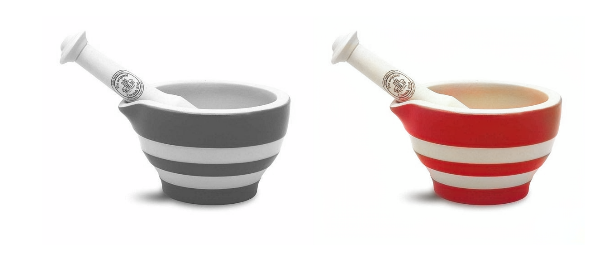

In [49]:
mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

# show result
plt.figure(figsize=(7,3))
plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres),axis=1)); plt.axis('off');

## Adding user inputs

Let's now add the ability to add user inputs. Function ```put_point()```, defined below, will add user input of color ```val``` at location ```loc``` with size ```(2p+1)x(2p+1)```.

In [13]:
def put_point(input_ab,mask,loc,p,val):
    # input_ab    2x256x256    current user ab input (will be updated)
    # mask        1x256x256    binary mask of current user input (will be updated)
    # loc         2 tuple      (h,w) of where to put the user input
    # p           scalar       half-patch size
    # val         2 tuple      (a,b) value of user input
    input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
    mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
    return (input_ab,mask)

Now, we will add a single blue point in the middle of the image, and see what the network predicts.

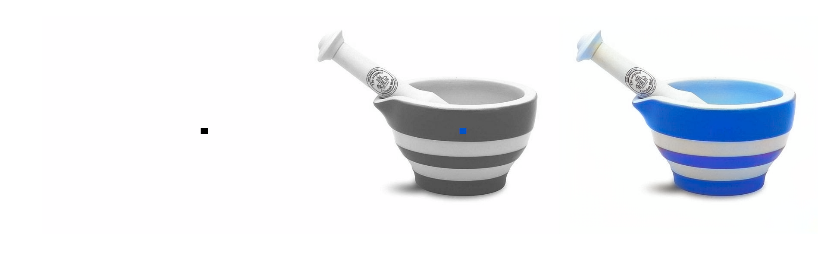

In [44]:
# initialize with no user inputs
input_ab = np.zeros((2,256,256))
mask = np.zeros((1,256,256))

# add a blue point in the middle of the image
(input_ab,mask) = put_point(input_ab,mask,[135,160],3,[23,-69])

# call forward
img_out = colorModel.net_forward(input_ab,mask)

# get mask, input image, and result in full resolution
mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

# show user input, along with output
plt.figure(figsize=(10,6))
plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
plt.axis('off');

The cup is blue! However, the result above has some leakage into the inside of the cup. Let's clean it up by placing a gray point inside of the cup.

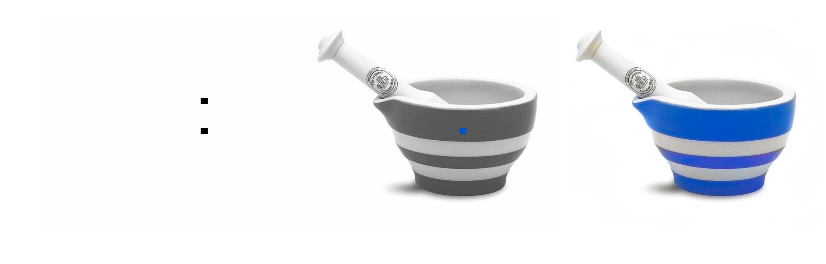

In [45]:
# add a gray point in the inside of the cup
(input_ab,mask) = put_point(input_ab,mask,[100,160],3,[0,0])

# call forward
img_out = colorModel.net_forward(input_ab,mask)

# get mask, input image, and result in full resolution
mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

# show user input, along with output
plt.figure(figsize=(10,6))
plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
plt.axis('off');

Now, we will take the blue control point and make it different colors by rotating around the ab gamut, and see what result we get.

In [40]:
input_ab = np.zeros((2,256,256))
mask = np.zeros((1,256,256))
(input_ab,mask) = put_point(input_ab,mask,[100,160],3,[0,0])

phis = np.arange(0,2*np.pi,np.pi/4)
img_outs = []
for (pp,phi) in enumerate(phis): # loop through angles, and change control point to different colors
    (input_ab,mask) = put_point(input_ab,mask,[135,160],3,[60*np.cos(phi),60*np.sin(phi)]) 
    colorModel.net_forward(input_ab,mask)
    img_outs.append(colorModel.get_img_fullres()[:,:,:,np.newaxis]) # get image at full resolution

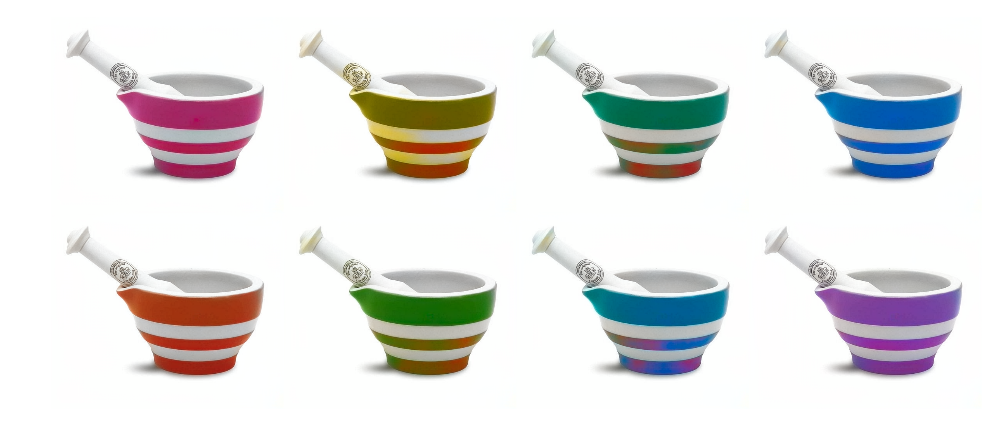

In [42]:
import rz_fcns_nohdf5 as rz # utility functions
img_outs_montage = rz.montage(np.concatenate(img_outs,axis=3),PAD=0,MM=2)

plt.figure(figsize=(12,8))
plt.imshow(img_outs_montage)
plt.axis('off');